In [1]:
import pandas as pd
from sklearn.utils import resample
df = pd.read_csv('train.csv')

In [ ]:
df.info()

In [2]:
#функция для разбиения возрастов по группам согласно гипотезе, приведенной в файле.
#group_size - параметр размера каждой группы
#результаты нужно обязательно подвергуть one-hot encoding, так как зависимость нелинейная
def get_age_group(age):
    group_size = 7
    if age <= 17:
        return 1
    if age > 66:
        age = 66
    return 1 + ((age - 17) // group_size)
print(get_age_group(18), get_age_group(27), get_age_group(45), get_age_group(60), get_age_group(80))

1 2 5 7 8


In [4]:
def get_pdays_group(pdays):
    if (pdays == 0) or (pdays == 999):
        return 1
    elif 2 <= pdays < 15:
        return 2
    return 3

print (get_pdays_group(999), get_pdays_group(0), get_pdays_group(3), get_pdays_group(20))

1 1 2 3


In [120]:
def preprocessing_optimal(df):
    df = df.drop(["_id", "age", 'job', "marital", "education", "default",
                 "housing", "loan", "day_of_week", 'campaign', 'previous', 'emp.var.rate', "cons.price.idx",
                 "cons.conf.idx", "euribor3m", 'pdays'], axis = 1)
    df = pd.get_dummies(df, columns=['contact', 'month', 'poutcome'])
    return df

def preprocessing_minimal(df):
    df["age_group"] = df["age"].map(get_age_group)
    df['pdays'] = df['pdays'].map(get_pdays_group)
    df['default'] = df['default'].map(lambda x: 'unknown' if x == 'yes' else x)
    
    df = df.drop(["_id", "age", "housing", "loan", "day_of_week"], axis = 1)
    #, "cons.price.idx", "cons.conf.idx", "euribor3m"
    df = pd.get_dummies(df, columns=["marital", "education", 'default', 'age_group', 'job', 'contact', 'month', 'poutcome'])
    return df

def preprocessing_1(df):
    
    df["age_group"] = df["age"].map(get_age_group)
    df['pdays'] = df['pdays'].map(get_pdays_group)
    df = df.drop(["_id", "age", "default",
                 "housing", "loan", "day_of_week", 'previous', "cons.price.idx",
                 "cons.conf.idx", "euribor3m", 'marital'], axis = 1)
    df = pd.get_dummies(df, columns=['age_group', 'contact', 'month', 'poutcome', 'pdays', 'job', 'education'])
    return df

def preprocessing(df_input, algorithm = preprocessing_minimal):
    return algorithm(df_input.copy())

In [121]:
from sklearn.preprocessing import StandardScaler
#обрабатываем данные инициализируем X и Y
df_prepared = preprocessing(df)
preprocessing(df).to_csv('temp.csv',index=False)
y = df_prepared['target']
X = StandardScaler().fit_transform(df_prepared.drop('target', axis=1))


In [126]:
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24712 entries, 0 to 24711
Data columns (total 59 columns):
duration                         24712 non-null int64
campaign                         24712 non-null int64
pdays                            24712 non-null int64
previous                         24712 non-null int64
emp.var.rate                     24712 non-null float64
cons.price.idx                   24712 non-null float64
cons.conf.idx                    24712 non-null float64
euribor3m                        24712 non-null float64
nr.employed                      24712 non-null float64
target                           24712 non-null int64
marital_divorced                 24712 non-null uint8
marital_married                  24712 non-null uint8
marital_single                   24712 non-null uint8
marital_unknown                  24712 non-null uint8
education_basic.4y               24712 non-null uint8
education_basic.6y               24712 non-null uint8
education_basic.9

In [122]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=12134)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17298, 58) (7414, 58) (17298,) (7414,)


C:\Users\Evgeny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

In [148]:
logreg = LogisticRegression(penalty='l1').fit(X_train, y_train)
decision_tree = DecisionTreeClassifier(max_depth = 7).fit(X_train, y_train)
random_forest = RandomForestClassifier(max_depth = 8).fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=50, metric='minkowski').fit(X_train, y_train)
elastic = ElasticNet(alpha=0.0001, l1_ratio=0.5).fit(X_train, y_train)

models = pd.DataFrame({'title': ["logreg", "decision_tree", "random_forest", "knn", "elastic"],
                       'predictions': [logreg.predict_proba(X_test)[:,1], 
                                         decision_tree.predict_proba(X_test)[:,1], 
                                         random_forest.predict_proba(X_test)[:,1], 
                                         knn.predict_proba(X_test)[:,1],
                                          elastic.predict(X_test)]})

models['roc_auc_proba'] = models['predictions'].map(lambda y_hat: roc_auc_score(y_test, y_hat))

step = 0.001
steps = 200
models['best_roc_auc'] = models['predictions'].map(
    lambda y_hat: max([roc_auc_score(y_test,[ 1 if y > (step * i) else 0 for y in y_hat]) for i in range(steps)]))
models['threshold'] = models['predictions'].map(
    lambda y_hat: step * np.argmax([roc_auc_score(y_test,[ 1 if y > (step * i) else 0 for y in y_hat]) for i in range(steps)]))
models                       

C:\Users\Evgeny\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,title,predictions,roc_auc_proba,best_roc_auc,threshold
0,logreg,"[0.11994676609049412, 0.013806563881302556, 0....",0.930915,0.875098,0.085
1,decision_tree,"[0.14285714285714285, 0.0038889391335805374, 0...",0.913542,0.860865,0.048
2,random_forest,"[0.26308197791265575, 0.018657402373295544, 0....",0.924409,0.873224,0.132
3,knn,"[0.1, 0.0, 0.1, 0.02, 0.06, 0.0, 0.04, 0.02, 0...",0.870529,0.805284,0.080
4,elastic,"[0.2060601628351671, -0.012894135236455315, 0....",0.930446,0.875413,0.164


In [125]:
logreg.coef_

array([[ 1.23009907e+00, -1.37406913e-01,  1.49602163e-01,
        -1.74890582e-02, -2.47440780e+00,  9.99613248e-01,
         4.71668061e-02,  8.61330492e-01,  0.00000000e+00,
         3.55388288e-02, -1.89757829e-03,  0.00000000e+00,
        -1.93567613e-02, -2.78137166e-02,  5.05782401e-02,
        -1.60028362e-03, -1.30833667e-02, -6.88290700e-02,
         0.00000000e+00,  6.73646585e-02,  2.92253530e-03,
         8.18377542e-02, -6.80237763e-02,  5.82840698e-02,
        -2.83040080e-03,  0.00000000e+00, -4.46438236e-02,
        -5.05817622e-02,  3.78822836e-02,  3.54893207e-02,
         8.02862832e-02,  4.93986849e-02, -7.70385013e-03,
         0.00000000e+00, -2.09244980e-04,  8.72366738e-03,
        -4.26576985e-02, -2.37272220e-02,  0.00000000e+00,
         1.52815837e-02,  6.53881957e-03,  4.09937613e-02,
        -1.08205167e-01,  1.17820119e-01, -2.29512742e-01,
         0.00000000e+00,  2.89035617e-01,  5.50359196e-03,
         8.25984060e-02, -7.61590103e-02,  2.29200701e-0

In [142]:

from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=0.0001, l1_ratio=0.5)

elastic.fit(X_train, y_train)

roc_auc_score(y_test, elastic.predict(X_test))

C:\Users\Evgeny\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.9304464166078509

In [143]:
elastic

array([ 1.19954359e-01,  2.37613936e-03,  2.49846181e-02, -3.29339477e-03,
       -2.36895632e-01,  8.69490841e-02,  9.99023443e-03,  1.56661530e-01,
       -6.93195603e-02,  1.13967455e-03,  0.00000000e+00, -8.75909460e-04,
       -1.53583830e-03, -7.62644721e-04,  3.35638079e-03,  0.00000000e+00,
       -6.10435032e-04, -2.40382233e-03, -3.31668510e-04,  4.99630366e-03,
        5.96296133e-04,  4.14319394e-03, -2.08317808e-04,  7.18612742e-03,
       -5.74050243e-04,  0.00000000e+00, -1.90950057e-03, -2.57521666e-03,
        1.34177287e-03,  2.20144338e-03,  8.90165687e-03,  3.65766520e-03,
       -0.00000000e+00,  2.11984785e-04, -2.10056083e-04,  0.00000000e+00,
       -1.93751587e-03, -8.31279092e-04, -2.01185879e-05,  2.02710169e-03,
        2.14400240e-03,  2.95956170e-03, -3.39698485e-03,  2.53672585e-02,
       -1.22310358e-03, -1.53034616e-03,  2.97819276e-02,  6.86907269e-04,
        1.32342183e-02,  0.00000000e+00,  3.05908351e-02, -1.82259829e-02,
       -8.69756749e-03, -

In [139]:
for i in np.logspace(-5, 0, 20):
    print(i, roc_auc_score(y_test, ElasticNet(alpha=i, l1_ratio=0.5).fit(X_train, y_train).predict(X_test)))

C:\Users\Evgeny\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


1e-05 0.9303864583556121
1.8329807108324375e-05 0.9303988887249787
3.359818286283781e-05 0.9304051039096619
6.158482110660267e-05 0.9304266742565039
0.00011288378916846884 0.9304487930019946
0.00020691380811147902 0.9304798689254111
0.000379269019073225 0.9304317926438902
0.0006951927961775605 0.9301921424344841
0.0012742749857031334 0.9293684476643975
0.002335721469090121 0.9284474121341977
0.004281332398719391 0.9284324225711378
0.007847599703514606 0.9286986701149973
0.01438449888287663 0.9284259331871303
0.026366508987303583 0.927445122204241
0.04832930238571752 0.9251047395718799
0.08858667904100823 0.9146928428309581
0.1623776739188721 0.9136739181419962
0.2976351441631319 0.5
0.5455594781168515 0.5
1.0 0.5


(-0.01, 1.01)

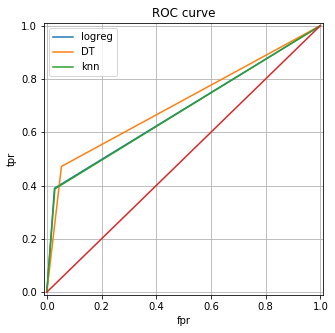

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict(X_test))
fpr2, tpr2, thresholds2 = roc_curve(y_test, decision_tree.predict(X_test))
#fpr3, tpr3, thresholds3 = roc_curve(y_test, random_forest.predict(X_test))
fpr4, tpr4, thresholds4 = roc_curve(y_test, knn.predict(X_test))
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='logreg')
plt.plot(fpr2, tpr2, label='DT')
#plt.plot(fpr3, tpr3, label='RF')
plt.plot(fpr4, tpr4, label='knn')
plt.plot([0, 1], [0, 1])
plt.legend()
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

In [149]:
#выбираем модель
best_model = random_forest
df_test = pd.read_csv('test.csv')
ids = df_test['_id']
test_data_prepared = StandardScaler().fit_transform(preprocessing(df_test))
df_test['target']= [ 1 if y > (0.084) else 0 for y in (best_model.predict_proba(test_data_prepared)[:, 1])]
#df_test['target'] = best_model.predict(test_data_prepared)
df_test[['_id','target']].to_csv('submit.csv',index=False)

PermissionError: [Errno 13] Permission denied: 'submit.csv'